In [47]:
# ============================================================
# 0) PROJECT: BSP 2025 – Alcohol, reaction time & physiology
# ============================================================

# Behavioural hypotheses
# H0: Alcohol does not change mean reaction time or RT variability
#     across the three conditions (sober, 1 drink, 2 drinks).
# H1: Alcohol increases RT variability (less consistent performance)
#     and may change mean reaction time across conditions.
#
# Physiological hypotheses
# H0: Alcohol does not change heart rate or RMSSD-like HRV
#     during the SART task.
# H1: Alcohol increases mean heart rate and decreases RMSSD-like HRV
#     during the SART task.
#
# Exploratory question
# - Do BMI and dosage affect the effect of alcohol on heart rate or RT variability?


In [48]:
# ============================================================
# 1) UNZIP DATA
# ============================================================

!unzip -o "/content/Project.zip" -d "/content/project_data" > /dev/null

import os, glob
import numpy as np
import pandas as pd
from scipy import stats

import xml.etree.ElementTree as ET
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

BASE_PATH       = "/content/project_data"
SART_PATH       = f"{BASE_PATH}/raw_sart"
TCX_PATH        = f"{BASE_PATH}/raw_tcx"
PARTICIPANT_XLS = f"{BASE_PATH}/participants.xlsx"

print(os.listdir(BASE_PATH))


['raw_tcx', 'rt_variability_summary.csv', 'hr_summary.csv', 'participants.xlsx', 'behavioral_summary_clean.csv', 'behavioral_summary.csv', 'combined_summary_clean.csv', 'raw_sart']


In [49]:
# ============================================================
# 2) PARSE SART .TXT FILES  → TRIAL-LEVEL DATA
# ============================================================

def parse_sart_file(path: str) -> pd.DataFrame:
    """
    Read one SART txt file.
    - Tab separated, no header, first few rows contain meta-info.
    - We skip the first 5 rows.
    Columns (based on task description):
      0: block name
      1: block number
      2: go (1) / no-go (0)
      3: digit (1–9)
      4: stimulus size (1–5)
      5: response outcome (0 = error/no response, 1 = correct)
      6: reaction time (ms)
    """
    df = pd.read_csv(
        path,
        sep="\t",
        header=None,
        skiprows=5,
        engine="python"
    )
    return df


In [50]:
# ============================================================
# 3) BEHAVIOURAL SUMMARY PER SUBJECT & CONDITION
#    + RT VARIABILITY (VAR / SD / MAD)
# ============================================================

behav_rows  = []
rtvar_rows  = []

for path in sorted(glob.glob(f"{SART_PATH}/*.txt")):
    fname = os.path.basename(path)          # e.g. "3_2.txt"
    name, _ = os.path.splitext(fname)
    subj_str, cond_str = name.split("_")
    subject_id = int(subj_str)
    condition  = int(cond_str)              # 0 = sober, 1 = 1 drink, 2 = 2 drinks

    df = parse_sart_file(path)

    # use only correct go-trials to compute RT
    go_correct = df[(df[2] == 1) & (df[5] == 1)]
    rt = go_correct[6].astype(float)

    # total number of SART trials
    n_trials = len(df)

    # errors
    n_commission = ((df[2] == 0) & (df[5] == 1)).sum()   # no-go + response
    n_omission   = ((df[2] == 1) & (df[5] == 0)).sum()   # go + no response

    accuracy = 1 - (n_commission + n_omission) / n_trials

    approx_duration_sec = 225.0   # fixed task duration (~225 s)

    behav_rows.append({
        "subject_id":        subject_id,
        "condition":         condition,
        "n_trials":          n_trials,
        "mean_rt_go_correct":   rt.mean(),
        "median_rt_go_correct": rt.median(),
        "std_rt_go_correct":    rt.std(ddof=1),
        "n_commission_errors":  int(n_commission),
        "n_omission_errors":    int(n_omission),
        "accuracy":          accuracy,
        "approx_duration_sec": approx_duration_sec
    })

    # RT variability metrics
    rt_var = rt.var(ddof=1)
    rt_std = rt.std(ddof=1)
    rt_mad = np.median(np.abs(rt - np.median(rt)))

    rtvar_rows.append({
        "subject_id":  subject_id,
        "condition":   condition,
        "rt_variance": rt_var,
        "rt_std":      rt_std,
        "rt_mad":      rt_mad
    })

behav_summary   = pd.DataFrame(behav_rows).sort_values(["subject_id", "condition"]).reset_index(drop=True)
rt_var_summary  = pd.DataFrame(rtvar_rows).sort_values(["subject_id", "condition"]).reset_index(drop=True)

behav_summary.to_csv(f"{BASE_PATH}/behavioral_summary.csv", index=False)
rt_var_summary.to_csv(f"{BASE_PATH}/rt_variability_summary.csv", index=False)

behav_summary.head()


,subject_id,condition,n_trials,mean_rt_go_correct,median_rt_go_correct,std_rt_go_correct,n_commission_errors,n_omission_errors,accuracy,approx_duration_sec
0,0,0,238,173.242857,149.5,117.930371,19,1,0.915966,225.0
1,0,1,238,170.905660,150.5,112.566318,20,0,0.915966,225.0
2,0,2,238,115.241935,75.5,113.863601,2,25,0.886555,225.0
3,1,0,238,128.599057,102.5,103.211992,14,0,0.941176,225.0
4,1,1,238,89.379147,70.0,72.258586,16,1,0.928571,225.0


In [51]:
# ============================================================
# 4) PARSE TCX HEART-RATE FILES → TIME SERIES
# ============================================================

def parse_tcx_hr(path: str) -> pd.DataFrame:
    """
    Extract HR time series from a TCX file.
    Returns DataFrame with:
      - time_sec: time in seconds from the first sample
      - hr_bpm:   heart rate in bpm
    """
    tree = ET.parse(path)
    root = tree.getroot()
    ns   = {"tcx": "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2"}

    times = []
    hrs   = []

    for tp in root.findall(".//tcx:Trackpoint", ns):
        t_el  = tp.find("tcx:Time", ns)
        hr_el = tp.find("tcx:HeartRateBpm/tcx:Value", ns)
        if t_el is None or hr_el is None:
            continue

        t = datetime.fromisoformat(t_el.text.replace("Z", "+00:00"))
        hr = int(hr_el.text)
        times.append(t)
        hrs.append(hr)

    if not times:
        return pd.DataFrame(columns=["time_sec", "hr_bpm"])

    t0 = times[0]
    time_sec = [(t - t0).total_seconds() for t in times]

    return pd.DataFrame({"time_sec": time_sec, "hr_bpm": hrs})


In [52]:
# ============================================================
# 5) HEART-RATE FEATURES PER SUBJECT & CONDITION
# ============================================================

def hr_features(hr_df: pd.DataFrame) -> dict:
    """
    Compute summary features from HR time series:
      - mean, median, std, min, max
      - RMSSD-like HRV (square root of mean squared successive differences)
      - number of samples
    """
    hr = hr_df["hr_bpm"].values.astype(float)
    n  = len(hr)
    if n == 0:
        return {
            "mean_hr":     np.nan,
            "median_hr":   np.nan,
            "std_hr":      np.nan,
            "min_hr":      np.nan,
            "max_hr":      np.nan,
            "rmssd_like":  np.nan,
            "n_samples":   0
        }

    diffs = np.diff(hr)
    rmssd = np.sqrt(np.mean(diffs**2)) if len(diffs) > 1 else np.nan

    return {
        "mean_hr":     hr.mean(),
        "median_hr":   np.median(hr),
        "std_hr":      hr.std(ddof=1) if n > 1 else 0.0,
        "min_hr":      hr.min(),
        "max_hr":      hr.max(),
        "rmssd_like":  rmssd,
        "n_samples":   int(n)
    }


In [53]:
# ============================================================
# 6) LOOP OVER TCX FILES, CUT TO TASK DURATION, SAVE HR SUMMARY
# ============================================================

hr_rows = []

for _, row in behav_summary.iterrows():
    subject_id = int(row["subject_id"])
    condition  = int(row["condition"])
    duration   = float(row["approx_duration_sec"])

    tcx_file = f"{TCX_PATH}/{subject_id}_{condition}.tcx"
    if not os.path.exists(tcx_file):
        print("Missing TCX:", tcx_file)
        continue

    hr_df   = parse_tcx_hr(tcx_file)
    hr_task = hr_df[hr_df["time_sec"] <= duration].copy()

    feats = hr_features(hr_task)
    feats["subject_id"] = subject_id
    feats["condition"]  = condition

    hr_rows.append(feats)

hr_summary = pd.DataFrame(hr_rows).sort_values(["subject_id", "condition"]).reset_index(drop=True)
hr_summary.to_csv(f"{BASE_PATH}/hr_summary.csv", index=False)

hr_summary.head()


Missing TCX: /content/project_data/raw_tcx/0_0.tcx
Missing TCX: /content/project_data/raw_tcx/0_1.tcx
Missing TCX: /content/project_data/raw_tcx/0_2.tcx


,mean_hr,median_hr,std_hr,min_hr,max_hr,rmssd_like,n_samples,subject_id,condition
0,104.962963,105.0,3.093333,98.0,113.0,1.260470,108,1,0
1,115.816092,116.0,4.545708,109.0,131.0,1.758699,87,1,1
2,123.518072,124.0,2.243481,119.0,128.0,1.059222,83,1,2
3,97.806723,98.0,1.270775,95.0,100.0,1.119927,119,2,0
4,103.930233,104.0,1.643459,100.0,108.0,1.062738,86,2,1


In [54]:
# ============================================================
# 7) MERGE: BEHAVIOUR + RT VARIABILITY + HR → FINAL TABLE
# ============================================================

# attach RT variance to behavioural summary (left join)
behav_full = behav_summary.merge(
    rt_var_summary,
    on=["subject_id", "condition"],
    how="left"
)

behav_full.to_csv(f"{BASE_PATH}/behavioral_summary_clean.csv", index=False)

# merge behaviour + HR only where both are available (inner join)
combined = behav_full.merge(
    hr_summary,
    on=["subject_id", "condition"],
    how="inner"
)

combined.to_csv(f"{BASE_PATH}/combined_summary_clean.csv", index=False)

combined.head()

data = combined.copy()


In [55]:
# ============================================================
# 8) ADD PARTICIPANTS (demographics) + BMI + alcohol dose
# ============================================================

participants = pd.read_excel(PARTICIPANT_XLS)

participants = participants.rename(columns={
    "Number": "subject_id",
    "Age": "age",
    "Weight (kg)": "weight_kg",
    "Height (cm)": "height_cm",
   })

for col in ["dose_1_mlkg", "dose_2_mlkg"]:
    participants[col] = (
        participants[col].astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

# BMI
participants["bmi"] = (
    participants["weight_kg"] / (participants["height_cm"] / 100) ** 2
)

# demographics (one row per subject)
participants_demo = participants[[
    "subject_id", "age", "weight_kg", "height_cm", "bmi"
]].copy()

# merge demographics by subject
data = data.merge(participants_demo, on="subject_id", how="left")

# alcohol dose per subject & condition
dose_rows = []
for _, row in participants.iterrows():
    sid = int(row["subject_id"])

    dose_rows.append({"subject_id": sid, "condition": 0, "dose_mlkg": 0.0})
    dose_rows.append({"subject_id": sid, "condition": 1, "dose_mlkg": row["dose_1_mlkg"]})
    dose_rows.append({"subject_id": sid, "condition": 2, "dose_mlkg": row["dose_2_mlkg"]})

dose_long = pd.DataFrame(dose_rows)

data = data.merge(dose_long, on=["subject_id", "condition"], how="left")

print(
    data[["subject_id", "condition",
          "mean_hr", "mean_rt_go_correct", "dose_mlkg"]].head()
)


   subject_id  condition     mean_hr  mean_rt_go_correct  dose_mlkg
0           1          0  104.962963          128.599057   0.000000
1           1          1  115.816092           89.379147   0.235294
2           1          2  123.518072          166.480583   0.470588
3           2          0   97.806723          137.094787   0.000000
4           2          1  103.930233          114.752381   0.285714


In [56]:
# ============================================================
# 9) NORMALISATION – Z-SCORED RT & HR (ACROSS SUBJECTS)
# ============================================================

data["mean_rt_z"] = stats.zscore(data["mean_rt_go_correct"], nan_policy="omit")
data["mean_hr_z"] = stats.zscore(data["mean_hr"],           nan_policy="omit")

print(
    data[["mean_rt_z", "mean_hr_z"]].mean().round(3),
    data[["mean_rt_z", "mean_hr_z"]].std(ddof=1).round(3)
)


mean_rt_z   -0.0
mean_hr_z    0.0
dtype: float64 mean_rt_z    1.019
mean_hr_z    1.019
dtype: float64


In [57]:
# ============================================================
# 10) DESCRIPTIVE STATISTICS BY CONDITION
#     (MEANS & SDs OF ALL KEY VARIABLES)
# ============================================================

rt_vars = ["mean_rt_go_correct", "median_rt_go_correct", "rt_variance", "rt_std", "rt_mad"]
hr_vars = ["mean_hr", "median_hr", "rmssd_like"]

desc = (
    data
    .groupby("condition")[rt_vars + hr_vars]
    .agg(["mean", "std"])
    .round(2)
)

desc


mean_rt_go_correct        median_rt_go_correct        rt_variance  \
                        mean    std                 mean    std        mean   
condition                                                                     
0                     124.04  40.53               109.22  64.17     8382.83   
1                     134.58  37.84               110.89  50.73    11769.18   
2                     140.51  32.43               141.78  54.30    10715.16   

                    rt_std        rt_mad        mean_hr        median_hr  \
               std    mean    std   mean    std    mean    std      mean   
condition                                                                  
0          2441.84   90.64  13.75  48.72  15.19   89.20  13.55     89.00   
1          5249.09  106.12  23.91  61.89  21.24  100.90   8.81    100.89   
2          3503.68  102.24  17.16  60.50  17.54  110.96  15.60    110.22   

                 rmssd_like        
             std       mean   std  
condition                          
0          13.66       1.24  0.41  
1           9.32       1.67  0.62  
2          16.28       1.21  0.65

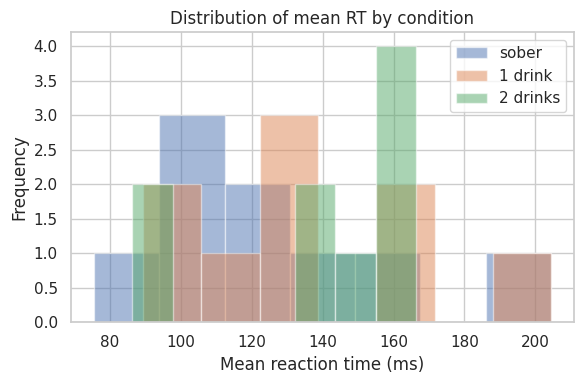

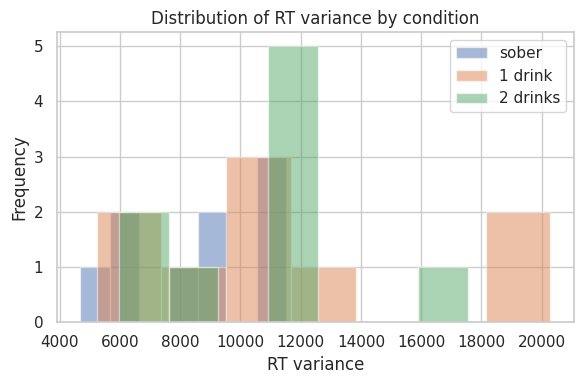

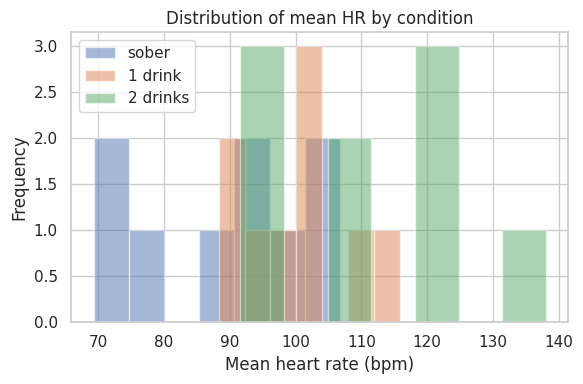

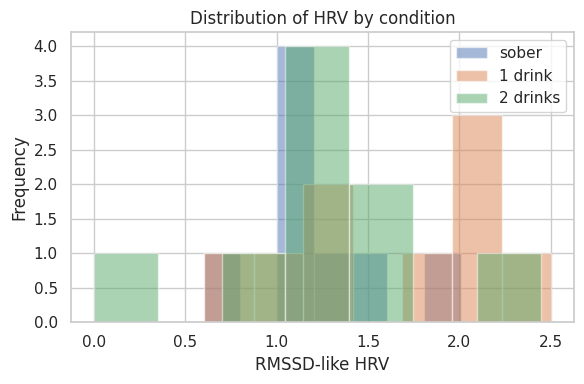

In [58]:
# ============================================================
# 11) DISTRIBUTION DIAGNOSTICS – HISTOGRAMS BY CONDITION
#     (USED BEFORE NORMALITY TESTS)
# ============================================================

cond_names = {0: "sober", 1: "1 drink", 2: "2 drinks"}

def hist_by_condition(var, xlabel, title, bins=7):
    plt.figure(figsize=(6, 4))
    for cond, label in cond_names.items():
        subset = data.loc[data["condition"] == cond, var]
        plt.hist(subset, bins=bins, alpha=0.5, label=label)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Reaction time
hist_by_condition(
    "mean_rt_go_correct",
    "Mean reaction time (ms)",
    "Distribution of mean RT by condition"
)

# RT variance
hist_by_condition(
    "rt_variance",
    "RT variance",
    "Distribution of RT variance by condition"
)

# Heart rate
hist_by_condition(
    "mean_hr",
    "Mean heart rate (bpm)",
    "Distribution of mean HR by condition"
)

# HRV
hist_by_condition(
    "rmssd_like",
    "RMSSD-like HRV",
    "Distribution of HRV by condition"
)


=== Dose–response for mean heart rate (bpm) ===
1st drink:  r = -0.550, p = 0.125
2nd drink:  r = -0.417, p = 0.265



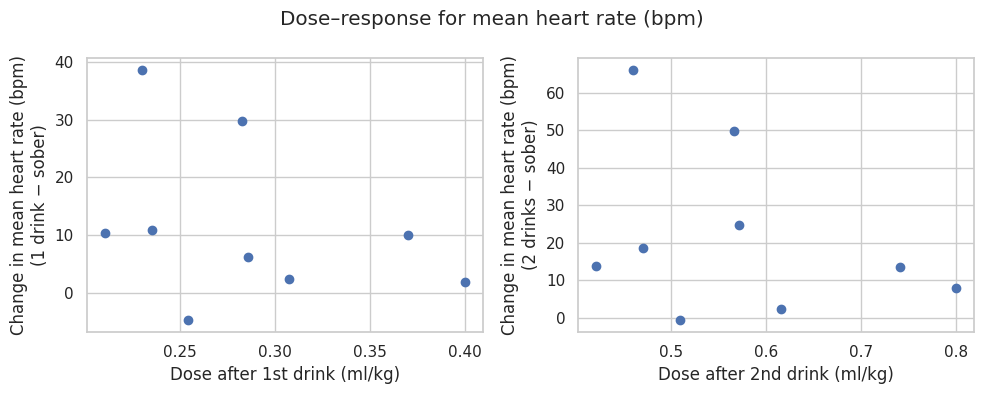

=== Dose–response for mean reaction time (ms) ===
1st drink:  r = 0.817, p = 0.007
2nd drink:  r = 0.533, p = 0.139



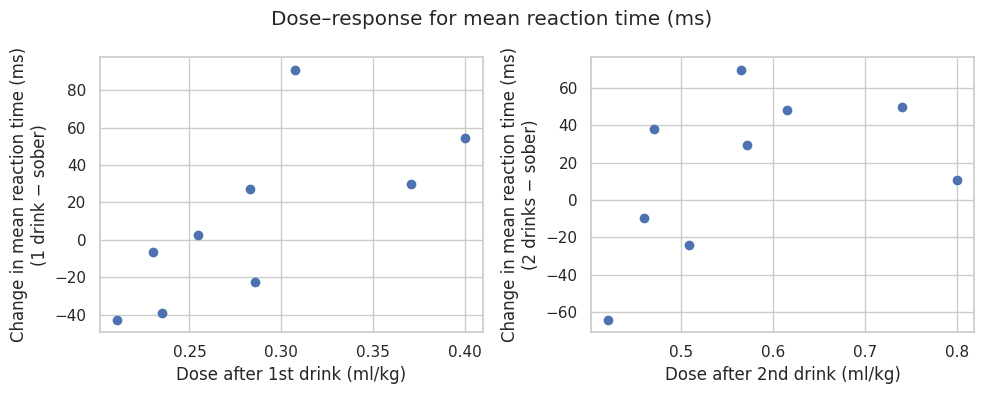

=== Dose–response for RT variance ===
1st drink:  r = 0.750, p = 0.020
2nd drink:  r = 0.517, p = 0.154



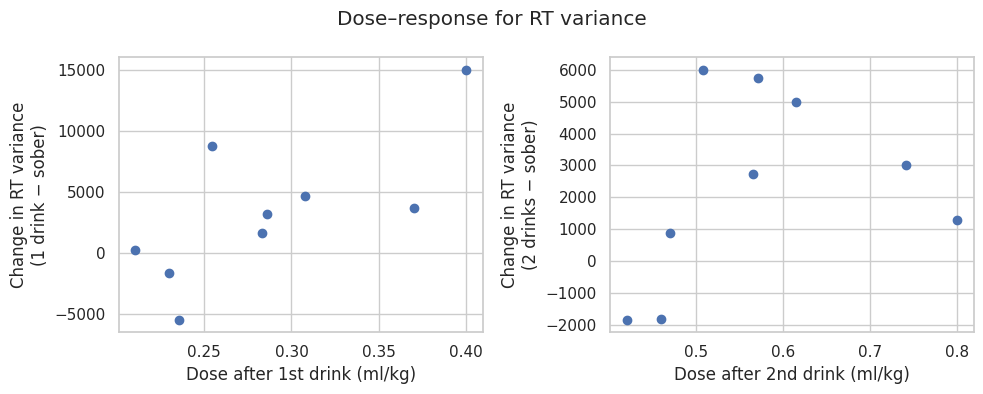

=== Dose–response for RMSSD-like HRV ===
1st drink:  r = nan, p = nan
2nd drink:  r = nan, p = nan



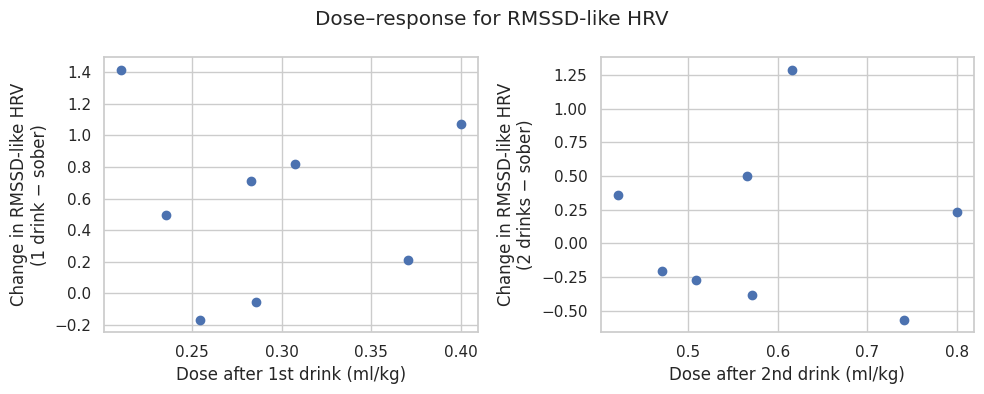

In [59]:
# ============================================================
# 11/b) Dose–response exploratory analysis
#      (change from sober vs. ml/kg alcohol dose)
# ============================================================

dose_info = participants[["subject_id", "dose_1_mlkg", "dose_2_mlkg"]].copy()

def dose_response(var, label):
    """
    For a given variable `var` (e.g. 'mean_hr'), compute
    change from sober to 1 drink and 2 drinks, then correlate
    these changes with the ml/kg alcohol dose.
    """
    # wide format: one row per subject, columns = condition
    wide = data.pivot(index="subject_id", columns="condition", values=var)

    wide = wide[[0, 1, 2]].rename(columns={
        0: "sober",
        1: "drink1",
        2: "drink2",
    })

    # within-subject changes relative to sober
    wide["delta_1"] = wide["drink1"] - wide["sober"]
    wide["delta_2"] = wide["drink2"] - wide["sober"]

    df = wide.merge(dose_info, on="subject_id")

    # Spearman correlations
    r1, p1 = stats.spearmanr(df["dose_1_mlkg"], df["delta_1"])
    r2, p2 = stats.spearmanr(df["dose_2_mlkg"], df["delta_2"])

    print(f"=== Dose–response for {label} ===")
    print(f"1st drink:  r = {r1:.3f}, p = {p1:.3f}")
    print(f"2nd drink:  r = {r2:.3f}, p = {p2:.3f}")
    print()

    # scatter plots
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(df["dose_1_mlkg"], df["delta_1"])
    plt.xlabel("Dose after 1st drink (ml/kg)")
    plt.ylabel(f"Change in {label}\n(1 drink − sober)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(df["dose_2_mlkg"], df["delta_2"])
    plt.xlabel("Dose after 2nd drink (ml/kg)")
    plt.ylabel(f"Change in {label}\n(2 drinks − sober)")
    plt.grid(True)

    plt.suptitle(f"Dose–response for {label}")
    plt.tight_layout()
    plt.show()

    return df

res_hr   = dose_response("mean_hr",           "mean heart rate (bpm)")
res_rt   = dose_response("mean_rt_go_correct","mean reaction time (ms)")
res_rtv  = dose_response("rt_variance",       "RT variance")
res_hrv  = dose_response("rmssd_like",        "RMSSD-like HRV")


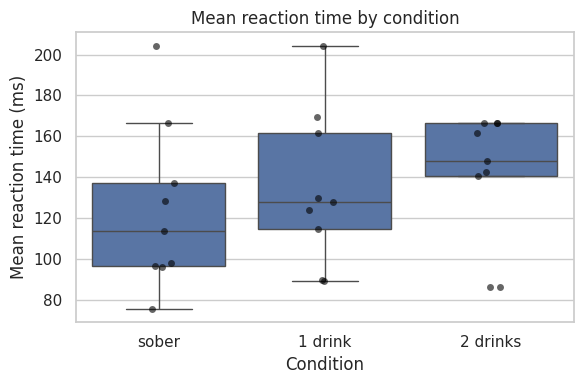

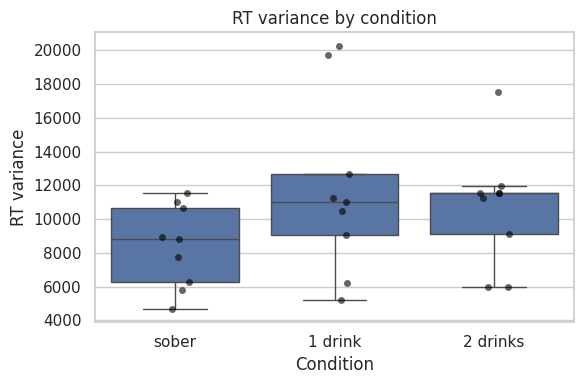

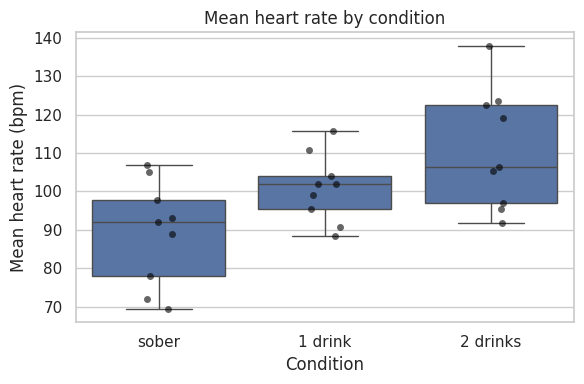

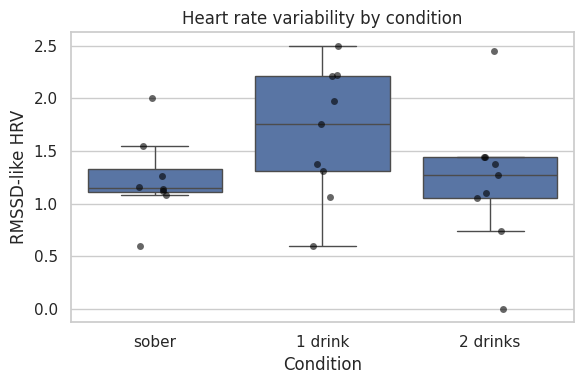

In [60]:
# ============================================================
# 12) BOXPLOTS + POINTS (STRIPPLOTS) BY CONDITION
# ============================================================

sns.set(style="whitegrid")

cond_labels = {0: "sober", 1: "1 drink", 2: "2 drinks"}
data["cond_label"] = data["condition"].map(cond_labels)

def box_strip(var, ylabel, title):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=data,
        x="cond_label", y=var,
        showfliers=False
    )
    sns.stripplot(
        data=data,
        x="cond_label", y=var,
        color="black",
        alpha=0.6
    )
    plt.xlabel("Condition")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# (1) Mean reaction time
box_strip(
    "mean_rt_go_correct",
    "Mean reaction time (ms)",
    "Mean reaction time by condition"
)

# (2) RT variance
box_strip(
    "rt_variance",
    "RT variance",
    "RT variance by condition"
)

# (3) Mean heart rate
box_strip(
    "mean_hr",
    "Mean heart rate (bpm)",
    "Mean heart rate by condition"
)

# (4) HRV (RMSSD-like)
box_strip(
    "rmssd_like",
    "RMSSD-like HRV",
    "Heart rate variability by condition"
)


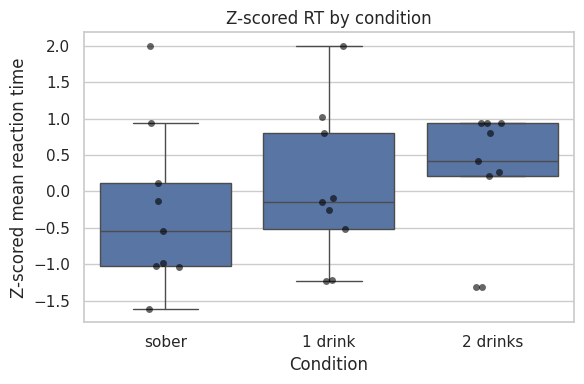

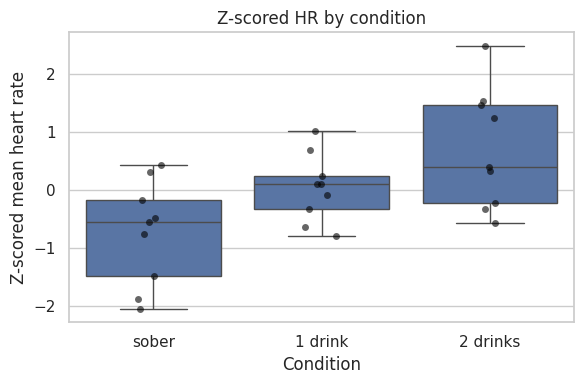

In [61]:
# ============================================================
# 13) Z-SCORED RT & HR BOXPLOTS
# ============================================================

box_strip(
    "mean_rt_z",
    "Z-scored mean reaction time",
    "Z-scored RT by condition"
)

box_strip(
    "mean_hr_z",
    "Z-scored mean heart rate",
    "Z-scored HR by condition"
)


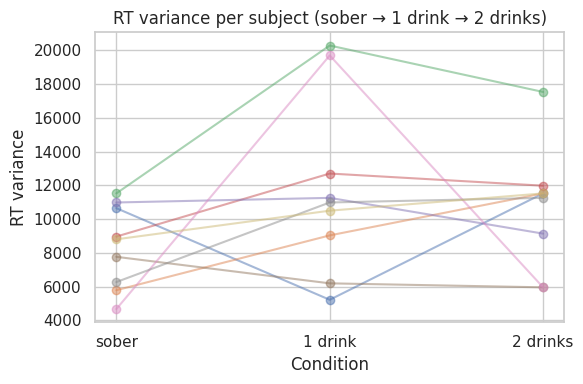

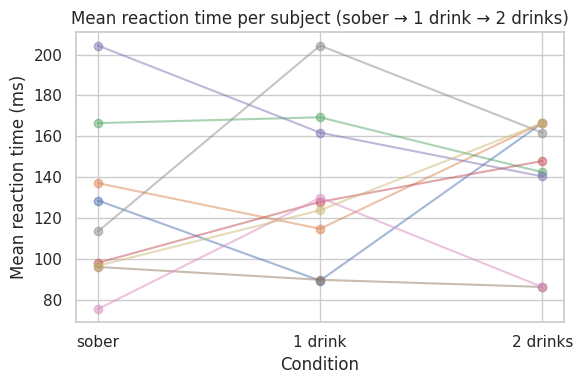

In [62]:
# ============================================================
# 14) WITHIN-SUBJECT TRAJECTORIES ("SPAGHETTI PLOT")
# ============================================================

def spaghetti(var, ylabel, title):
    plt.figure(figsize=(6, 4))
    for sid, sub_df in data.groupby("subject_id"):
        sub_df = sub_df.sort_values("condition")
        plt.plot(
            sub_df["condition"],
            sub_df[var],
            "-o",
            alpha=0.5
        )
    plt.xticks([0, 1, 2], ["sober", "1 drink", "2 drinks"])
    plt.xlabel("Condition")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

spaghetti(
    "rt_variance",
    "RT variance",
    "RT variance per subject (sober → 1 drink → 2 drinks)"
)

spaghetti(
    "mean_rt_go_correct",
    "Mean reaction time (ms)",
    "Mean reaction time per subject (sober → 1 drink → 2 drinks)",
)

In [63]:
# ============================================================
# 15) NORMALITY TESTS (SHAPIRO–WILK) BY CONDITION
# ============================================================

def shapiro_by_condition(df, var):
    print(f"=== Shapiro–Wilk: {var} ===")
    for cond in [0, 1, 2]:
        vals = df.loc[df["condition"] == cond, var]
        W, p = stats.shapiro(vals)
        print(f"  condition {cond}: W = {W:.3f}, p = {p:.3f}")
    print()

for v in ["mean_rt_go_correct", "rt_variance", "mean_hr", "rmssd_like"]:
    shapiro_by_condition(data, v)


=== Shapiro–Wilk: mean_rt_go_correct ===
  condition 0: W = 0.916, p = 0.359
  condition 1: W = 0.934, p = 0.521
  condition 2: W = 0.765, p = 0.008

=== Shapiro–Wilk: rt_variance ===
  condition 0: W = 0.943, p = 0.609
  condition 1: W = 0.896, p = 0.230
  condition 2: W = 0.875, p = 0.139

=== Shapiro–Wilk: mean_hr ===
  condition 0: W = 0.933, p = 0.510
  condition 1: W = 0.971, p = 0.904
  condition 2: W = 0.937, p = 0.552

=== Shapiro–Wilk: rmssd_like ===
  condition 0: W = nan, p = nan
  condition 1: W = 0.960, p = 0.803
  condition 2: W = 0.925, p = 0.436



In [64]:
# ============================================================
# 16) NON-PARAMETRIC REPEATED-MEASURES STATS
#     FRIEDMAN TEST + WILCOXON POST-HOC (HOLM CORRECTION)
# ============================================================

def friedman_for_var(df, var):
    # pivot to wide format: one column per condition
    wide = df.pivot(index="subject_id", columns="condition", values=var)
    wide = wide.dropna()    # ensure complete data for all 3 conditions

    stat, p = stats.friedmanchisquare(wide[0], wide[1], wide[2])
    print(f"=== Friedman test: {var} ===")
    print(f"  χ2 = {stat:.3f}, p = {p:.4f}")
    return wide

wide_rtvar  = friedman_for_var(data, "rt_variance")
wide_meanrt = friedman_for_var(data, "mean_rt_go_correct")
wide_meanhr = friedman_for_var(data, "mean_hr")
wide_rmssd  = friedman_for_var(data, "rmssd_like")


=== Friedman test: rt_variance ===
  χ2 = 4.222, p = 0.1211
=== Friedman test: mean_rt_go_correct ===
  χ2 = 0.667, p = 0.7165
=== Friedman test: mean_hr ===
  χ2 = 10.889, p = 0.0043
=== Friedman test: rmssd_like ===
  χ2 = 4.750, p = 0.0930


In [65]:
# ------------------------------------------------------------
# Wilcoxon signed-rank post-hoc tests with Holm–Bonferroni
# ------------------------------------------------------------

def pairwise_wilcoxon(wide, label):
    pairs   = [(0, 1), (0, 2), (1, 2)]
    results = []

    for a, b in pairs:
        stat, p = stats.wilcoxon(wide[a], wide[b])
        results.append({"pair": f"{a} vs {b}", "p_raw": p})

    res_df = pd.DataFrame(results)
    res_df = res_df.sort_values("p_raw")

    # Holm–Bonferroni
    m = len(res_df)
    adj_ps = []
    for i, p in enumerate(res_df["p_raw"], start=1):
        adj_ps.append(min((m - i + 1) * p, 1.0))
    res_df["p_holm"] = adj_ps

    print(f"\n=== Wilcoxon post-hoc ({label}) ===")
    print(res_df)
    return res_df

post_rtvar  = pairwise_wilcoxon(wide_rtvar,  "rt_variance")
post_meanrt = pairwise_wilcoxon(wide_meanrt, "mean_rt_go_correct")
post_meanhr = pairwise_wilcoxon(wide_meanhr, "mean_hr")
post_rmssd  = pairwise_wilcoxon(wide_rmssd,  "rmssd_like")



=== Wilcoxon post-hoc (rt_variance) ===
     pair     p_raw    p_holm
1  0 vs 2  0.074219  0.222656
0  0 vs 1  0.128906  0.257812
2  1 vs 2  0.820312  0.820312

=== Wilcoxon post-hoc (mean_rt_go_correct) ===
     pair     p_raw    p_holm
1  0 vs 2  0.250000  0.750000
0  0 vs 1  0.652344  1.000000
2  1 vs 2  0.910156  0.910156

=== Wilcoxon post-hoc (mean_hr) ===
     pair     p_raw    p_holm
1  0 vs 2  0.007812  0.023438
2  1 vs 2  0.007812  0.015625
0  0 vs 1  0.019531  0.019531

=== Wilcoxon post-hoc (rmssd_like) ===
     pair     p_raw    p_holm
0  0 vs 1  0.039062  0.117188
2  1 vs 2  0.054688  0.109375
1  0 vs 2  0.843750  0.843750


In [66]:
# ============================================================
# 17) BMI – RELATION TO RT & HR
#     (CORRELATIONS + SCATTER PLOTS)
# ============================================================

# numeric correlations
rt_vars = ["mean_rt_go_correct", "rt_variance", "rt_std", "rt_mad"]
print()
print("Correlations between BMI and reaction-time related variables:")
for v in rt_vars:
    corr = data[["bmi", v]].corr().iloc[0, 1]
    print(f"  BMI vs {v}: r = {corr:.3f}")

hr_vars = ["mean_hr", "median_hr", "rmssd_like"]
print("\nCorrelations between BMI and heart-rate related variables:")
for v in hr_vars:
    corr = data[["bmi", v]].corr().iloc[0, 1]
    print(f"  BMI vs {v}: r = {corr:.3f}")



Correlations between BMI and reaction-time related variables:
  BMI vs mean_rt_go_correct: r = -0.141
  BMI vs rt_variance: r = -0.222
  BMI vs rt_std: r = -0.201
  BMI vs rt_mad: r = -0.213

Correlations between BMI and heart-rate related variables:
  BMI vs mean_hr: r = 0.218
  BMI vs median_hr: r = 0.230
  BMI vs rmssd_like: r = -0.495


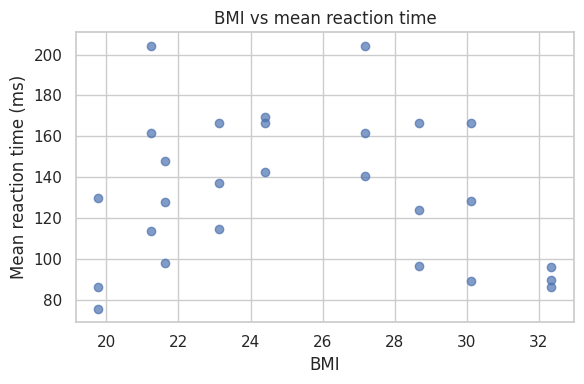

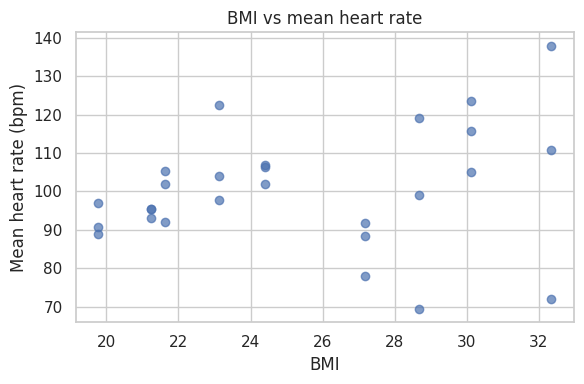

In [67]:
# Scatter plots: BMI vs mean RT and BMI vs mean HR
plt.figure(figsize=(6, 4))
plt.scatter(data["bmi"], data["mean_rt_go_correct"], alpha=0.7)
plt.xlabel("BMI")
plt.ylabel("Mean reaction time (ms)")
plt.title("BMI vs mean reaction time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(data["bmi"], data["mean_hr"], alpha=0.7)
plt.xlabel("BMI")
plt.ylabel("Mean heart rate (bpm)")
plt.title("BMI vs mean heart rate")
plt.tight_layout()
plt.show()


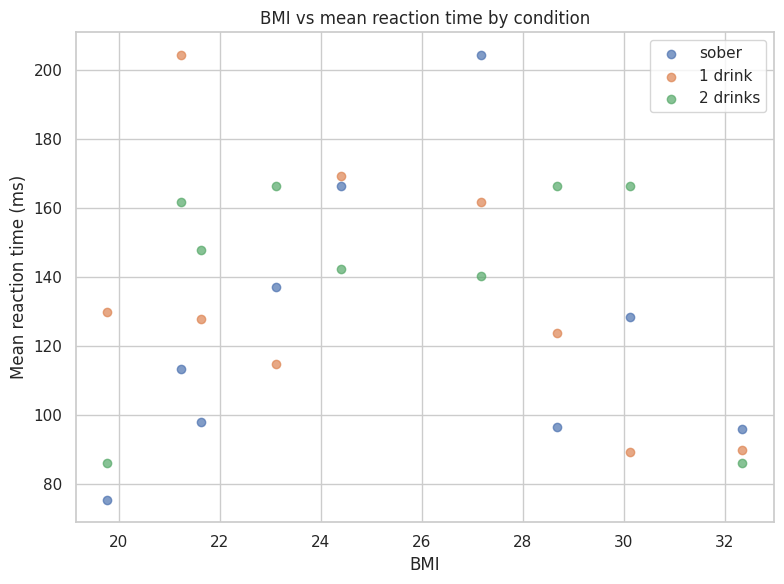

In [68]:
# Scatter: BMI vs mean RT, colour-coded by condition
conds = {0: "sober", 1: "1 drink", 2: "2 drinks"}

plt.figure(figsize=(8, 6))
for cond, label in conds.items():
    subset = data[data["condition"] == cond]
    plt.scatter(subset["bmi"], subset["mean_rt_go_correct"], label=label, alpha=0.7)

plt.xlabel("BMI")
plt.ylabel("Mean reaction time (ms)")
plt.title("BMI vs mean reaction time by condition")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


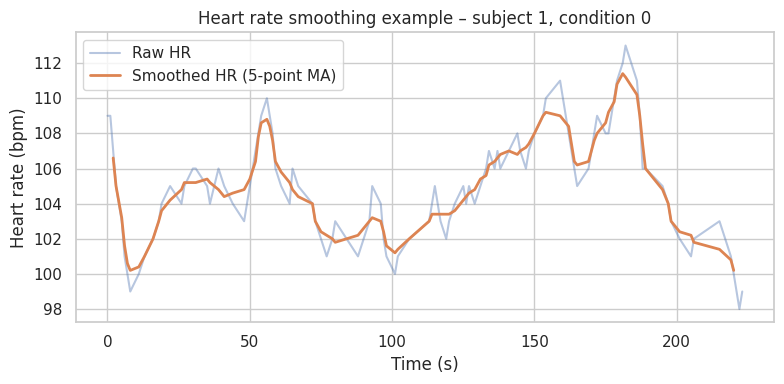

In [69]:
# ============================================================
# 18) NOISE REDUCTION DEMO – MOVING AVERAGE SMOOTHING ON HR
#     (EXAMPLE SUBJECT & CONDITION)
# ============================================================

example_subject   = 1
example_condition = 0   # 0 = sober

tcx_file = f"{TCX_PATH}/{example_subject}_{example_condition}.tcx"

if os.path.exists(tcx_file):
    # parse HR as before
    hr_df = parse_tcx_hr(tcx_file)

    # cut to task duration based on behavioural summary
    duration = float(
        behav_summary.loc[
            (behav_summary["subject_id"] == example_subject) &
            (behav_summary["condition"]  == example_condition),
            "approx_duration_sec"
        ].iloc[0]
    )
    hr_task = hr_df[hr_df["time_sec"] <= duration].copy()

    # simple moving average smoothing (window = 5 samples)
    hr_task["hr_smooth"] = hr_task["hr_bpm"].rolling(window=5, center=True).mean()

    plt.figure(figsize=(8, 4))
    plt.plot(hr_task["time_sec"], hr_task["hr_bpm"],       alpha=0.4, label="Raw HR")
    plt.plot(hr_task["time_sec"], hr_task["hr_smooth"], linewidth=2, label="Smoothed HR (5-point MA)")
    plt.xlabel("Time (s)")
    plt.ylabel("Heart rate (bpm)")
    plt.title(f"Heart rate smoothing example – subject {example_subject}, condition {example_condition}")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No TCX file found for the chosen example subject/condition.")
